In [ ]:
#テキストファイルでパイナップルの(頂点+色)を取得
#maisuごとにDCT、IDCTする
#32bit演算
#YCbCrでPSNR計算してる→ひとまずYCbCrでやる

In [29]:
#量子化テーブルの作成
import numpy as np

bairituY = 6
bairituC = 1.25
dc = 5

tableY = np.zeros((8,8))
ryoshi_Y = np.array([[dc,  11,  10,  16,  24,  40,  51,  61 ],
[ 12,  12,  14,  19,  26,  58,  60,  55 ],
[ 14,  13,  16,  24,  40,  57,  69,  56 ],
[ 14,  17,  22,  29,  51,  87,  80,  62 ],
[ 18,  22,  37,  56,  68, 109, 103,  77 ],
[ 24,  35,  55,  64,  81, 104, 113,  92 ],
[ 49,  64,  78,  87, 103, 121, 120, 101 ],
[ 72,  92,  95,  98, 112, 100, 103,  99 ]])

tableY = (ryoshi_Y*bairituY).astype(np.int32)
tableY[tableY < 1] = 1
print(tableY)

tableC = np.zeros((8,8))
ryoshi_C = np.array([[dc*8,  18,  24,  47,  99,  99,  99 , 99 ],
[ 18,  21,  26,  66,  99,  99,  99,  99 ],
[ 24,  26,  56,  99,  99,  99,  99,  99 ],
[ 47,  66,  99,  99,  99,  99,  99,  99 ],
[ 99,  99,  99,  99,  99,  99,  99,  99 ],
[ 99,  99,  99,  99,  99,  99,  99,  99 ],
[ 99,  99,  99,  99,  99,  99,  99,  99 ],
[ 99,  99,  99,  99,  99,  99,  99,  99 ]])


tableC = (ryoshi_C*bairituC).astype(np.int32)
tableC[tableC<1] =1
print(tableC)

[[ 30  66  60  96 144 240 306 366]
 [ 72  72  84 114 156 348 360 330]
 [ 84  78  96 144 240 342 414 336]
 [ 84 102 132 174 306 522 480 372]
 [108 132 222 336 408 654 618 462]
 [144 210 330 384 486 624 678 552]
 [294 384 468 522 618 726 720 606]
 [432 552 570 588 672 600 618 594]]
[[ 50  22  30  58 123 123 123 123]
 [ 22  26  32  82 123 123 123 123]
 [ 30  32  70 123 123 123 123 123]
 [ 58  82 123 123 123 123 123 123]
 [123 123 123 123 123 123 123 123]
 [123 123 123 123 123 123 123 123]
 [123 123 123 123 123 123 123 123]
 [123 123 123 123 123 123 123 123]]


In [15]:
#DCT
import numpy as np

def proposed_stage_1(x):
    X = np.zeros((8,))
    X[0] = x[0] + x[7]
    X[1] = x[1] + x[6]
    X[2] = x[2] + x[5]
    X[3] = x[3] + x[4]
    X[4] = x[3] - x[4]
    X[5] = x[2] - x[5]
    X[6] = x[1] - x[6]
    X[7] = x[0] - x[7]
    return X

def proposed_stage_2(x):
    X = np.zeros((8,))
    X[0] = x[0] + x[3]
    X[1] = x[1] + x[2]
    X[2] = x[1] - x[2]
    X[3] = x[0] - x[3]
    X[4] = x[5] - x[4] - x[6]
    X[5] = x[4] - x[5] + x[7]
    X[6] = x[4] - x[6] + x[7]
    X[7] = x[5] + x[6] + x[7]
    return X

def proposed_stage_3(x):
    X = np.zeros((8,))
    X[0] = x[0] + x[1]
    X[4] = x[0] - x[1]
    X[6] = -x[2]
    X[2] = x[3]
    X[7] = x[4]
    X[3] = x[5]
    X[5] = x[6]
    X[1] = x[7]
    return X

def proposed_stage_1_inverse(X):
    x = np.zeros((8,))
    x[0] = 0.5 * (X[0] + X[7])
    x[1] = 0.5 * (X[1] + X[6])
    x[2] = 0.5 * (X[2] + X[5])
    x[3] = 0.5 * (X[3] + X[4])
    x[4] = 0.5 * (X[3] - X[4])
    x[5] = 0.5 * (X[2] - X[5])
    x[6] = 0.5 * (X[1] - X[6])
    x[7] = 0.5 * (X[0] - X[7])
    return x

def proposed_stage_2_inverse(X):
    x = np.zeros((8,))
    x[0] = (X[0] + X[3]) / 2
    x[1] = (X[1] + X[2]) / 2
    x[2] = (X[1] - X[2]) / 2
    x[3] = (X[0] - X[3]) / 2
    x[4] = -X[4] -X[5] + X[6]
    x[5] = -X[4]/3 - X[5] + 2*X[6]/3 + X[7]/3
    x[6] = -X[4]/3 - X[6]/3 + X[7]/3
    x[7] = 2*X[4]/3 + X[5] - X[6]/3 + X[7]/3
    return x

def proposed_stage_3_inverse(X):
    x = np.zeros((8,))
    x[0] = (X[0] + X[4]) / 2
    x[1] = (X[0] - X[4]) / 2
    x[2] = -X[6]
    x[3] = X[2]
    x[4] = X[7]
    x[5] = X[3]
    x[6] = X[5]
    x[7] = X[1]
    return x

def DCT1(x):
    X_1 = proposed_stage_1(x)
    X_2 = proposed_stage_2(X_1)
    X_3 = proposed_stage_3(X_2)
    return X_3

def IDCT1(X_3):
    X_2 = proposed_stage_3_inverse(X_3)
    X_1 = proposed_stage_2_inverse(X_2)
    x = proposed_stage_1_inverse(X_1)
    return x

def tenchi2D(x):
    x = np.transpose(x)
    return x

def DCT_2D(x):
    X_out1 = np.zeros((8,8))
    X_out2 = np.zeros((8,8))
    for i in range(8):
        X_out1[i] = DCT1(x[i])
    X_out1 = tenchi2D(X_out1)
    for i in range(8):
        X_out2[i] = DCT1(X_out1[i])
    return X_out2
    
def IDCT_2D(X_out2):
    X_out1 = np.zeros((8,8))
    x = np.zeros((8,8))
    for i in range(8):
        X_out1[i] = IDCT1(X_out2[i])
    #転置
    X_out1 = tenchi2D(X_out1)
    # ｘ方向
    for i in range(8):
        x[i] = IDCT1(X_out1[i])
    return x

[[228. 102.  83. 150.  80. 117. 206. 147.]
 [186. 144. 142. 124. 147. 135. 148.  93.]
 [ 92. 198. 216. 108. 171. 170.  90. 153.]
 [134. 136. 154. 159.  73. 148. 161.  88.]
 [190. 107. 122. 184. 148. 110. 183. 102.]
 [101. 101.  98.  82. 105. 121. 114. 229.]
 [197. 108. 215. 211. 193. 166.  97. 105.]
 [211. 216. 211. 160. 190. 128. 135. 173.]]
[[309  -3   5  -6   1   0   0   1]
 [  5   0   1  -4   0   0   0   0]
 [  1   0   2   2   0   0   0   0]
 [  2   2   0   1   1   0   0   0]
 [  1  -2   0   0   0   0   0   0]
 [  2   0   0   0   1   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]]
最も多い要素数を持つ8x8配列のインデックス: 310
0でない要素の数: 30
[[225  92  50  35 118 220 178 131]
 [149 146 125 103 145 143 123 109]
 [144 220 243 219 173  98 121 115]
 [119 175 237 255 135  61 123  95]
 [175  72  48  74 124 197 173 129]
 [155  84  54  56 117 167 137 172]
 [150 158 172 172 145 122 135 178]
 [169 207 255 255 130  62 141 165]]
11015.0
6632.0
5675.0


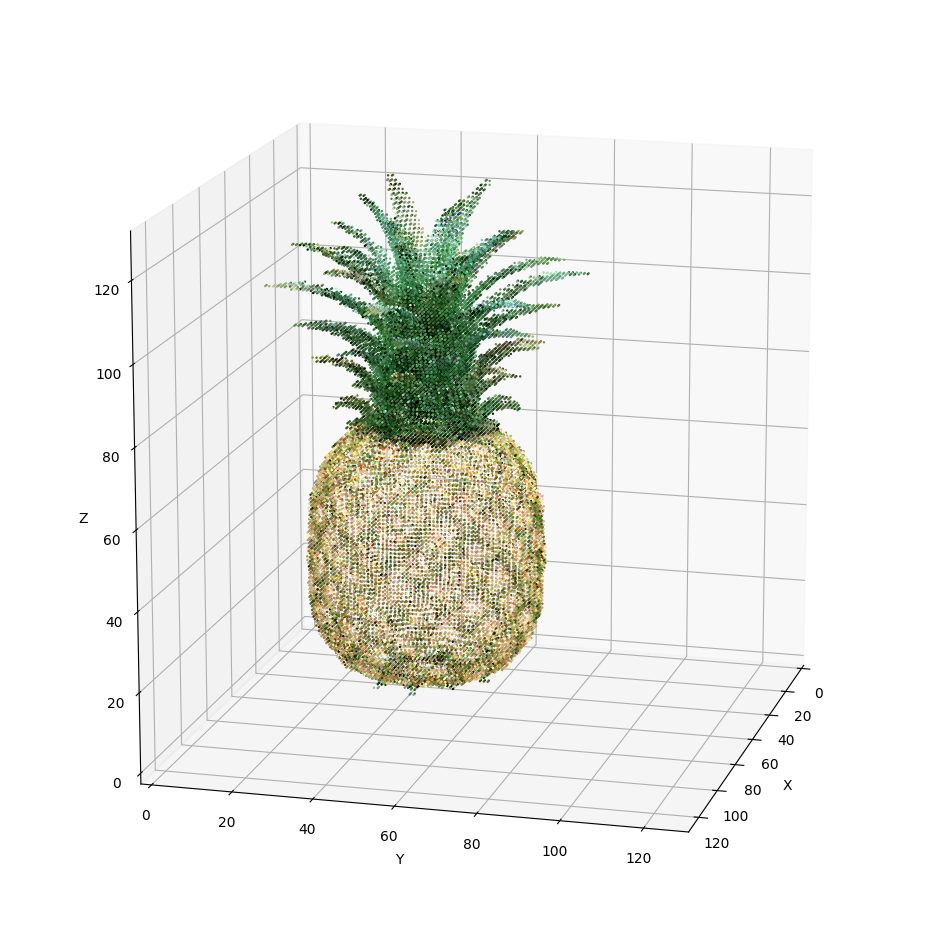

In [30]:
#表示
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

nonzeroY = np.array([])
nonzeroCr = np.array([])
nonzeroCb = np.array([])

vertex_color = np.loadtxt('path_vertex_color.txt')
colors = vertex_color[:,3:6]
dot = colors.shape[0]

#成分の入れ替え
colors_BGR = colors[:, ::-1]

#実験：小さい範囲に正規化する
#この場合量子化テーブルを小さくする必要がある
#正規化するのはRGBじゃなくてYCrCbのほうがいいかも
colors_BGR = colors_BGR

colors_add = np.zeros((64,3))
colors_BGR = np.concatenate([colors_BGR, colors_add], 0).astype(np.uint8)

#枚数を計算
maisu = dot//64 + 1

#発光デバイスを8*8ごとに分割
colors88 = np.zeros((maisu,8,8,3))
k = 0
for m in range(maisu):
    for i in range(8):
        for j in range(8):
            colors88[m,i,j] = colors_BGR[k]
            k = k + 1

#データ形式をuint8に変換
colors88 = colors88.astype(np.uint8)

#色変換，要素ごとに分割、正規化
for i in range(maisu):
    colors88[i,:,:,:] = cv2.cvtColor(colors88[i,:,:,:], cv2.COLOR_BGR2YCrCb)
Y = colors88[:,:,:,0].astype(np.float16)
Cr = colors88[:,:,:,1].astype(np.float16)
Cb = colors88[:,:,:,2].astype(np.float16)

print(Y[1,:,:])

#変換，量子化
for i in range(maisu):
    Y[i,:,:] = DCT_2D(Y[i,:,:])
    Cr[i,:,:] = DCT_2D(Cr[i,:,:])
    Cb[i,:,:] = DCT_2D(Cb[i,:,:])
    Y[i,:,:] = Y[i,:,:]/tableY
    Cr[i,:,:] = Cr[i,:,:]/tableC
    Cb[i,:,:] = Cb[i,:,:]/tableC
    Y[i,:,:] = Y[i,:,:].astype(np.int32)
    Cr[i,:,:] = Cr[i,:,:].astype(np.int32)
    Cb[i,:,:] = Cb[i,:,:].astype(np.int32)

    nonzeroY = np.append(nonzeroY, (np.count_nonzero(Y[i,:,:])))
    nonzeroCr = np.append(nonzeroCr, (np.count_nonzero(Cr[i,:,:])))
    nonzeroCb = np.append(nonzeroCb, (np.count_nonzero(Cb[i,:,:])))

#ここからは整数しか使えない
Y = Y.astype(np.int32)
Cr = Cr.astype(np.int32)
Cb = Cb.astype(np.int32)

print(Y[1,:,:])



non_zero_counts = np.count_nonzero(Y, axis=(1, 2))
max_index = np.argmax(non_zero_counts)
max_non_zero_count = non_zero_counts[max_index]
print("最も多い要素数を持つ8x8配列のインデックス:", max_index)
print("0でない要素の数:", max_non_zero_count)

#復元
for i in range(maisu):
    Y[i,:,:] = Y[i,:,:]*tableY
    Cr[i,:,:] = Cr[i,:,:]*tableC
    Cb[i,:,:] = Cb[i,:,:]*tableC

for i in range(maisu):
    """if i == 1:
        print(Y[i,:,:])
        print(Cr[i,:,:])
        print(Cb[i,:,:])"""
    Y[i,:,:] = IDCT_2D(Y[i,:,:])
    Cr[i,:,:] = IDCT_2D(Cr[i,:,:])
    Cb[i,:,:] = IDCT_2D(Cb[i,:,:])

Y[Y>255] = 255
Cr[Y>255] = 255
Cb[Y>255] = 255
Y[Y<0] = 0
Cr[Y<0] = 0
Cb[Y<0] = 0

Y_recrypt = Y.astype(np.uint8)
Cr_recrypt = Cr.astype(np.uint8)
Cb_recrypt = Cb.astype(np.uint8) 

print(Y_recrypt[1])

colors88_recrypt = np.stack([Y_recrypt, Cr_recrypt, Cb_recrypt],-1)

#BGRに変換(ここで乗算が必要になる)
for i in range(maisu):
    colors88_recrypt[i,:,:,:] = cv2.cvtColor(colors88_recrypt[i,:,:,:], cv2.COLOR_YCrCb2BGR)

#8*8から一列に
colors_BGR_recrypt = np.zeros((dot + 64,3))
k = 0
for m in range(maisu):
    for i in range(8):
        for j in range(8):
            colors_BGR_recrypt[k] = colors88_recrypt[m,i,j]
            k = k + 1

#表示できるように
colors_RGB_recrypt = colors_BGR_recrypt[:, ::-1]
colors_RGB_recrypt = colors_RGB_recrypt[0:dot, :]
colors_RGB_recrypt = colors_RGB_recrypt.astype(np.int32)
vertex = vertex_color[:,0:3].astype(np.int32)
vertex_colors_recrypt = np.concatenate([vertex, colors_RGB_recrypt], -1)
colors_recrypt = vertex_colors_recrypt[:,3:6]
colors_recrypt_seikika = colors_recrypt/255

print(np.sum(nonzeroY))
print(np.sum(nonzeroCr))
print(np.sum(nonzeroCb))

#像の表示
fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(projection='3d')
ax.set_title("", size = 20)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_xlim(0,128)
ax.set_ylim(0,128)
ax.set_zlim(0,129)
ax.scatter(vertex_colors_recrypt[:,0], vertex_colors_recrypt[:,1], vertex_colors_recrypt[:,2], s = 0.5, c = colors_recrypt_seikika, alpha =1)
ax.view_init(elev=15, azim=15)
ax.set_aspect('equal')
ax.axis("on")
plt.show()

#逆の操作をして元の配列に色を戻して表示する
#DCT量子化後の配列の０でない要素の値の数を調べる